<a href="https://colab.research.google.com/github/abhizc/EVA4-B2/blob/master/S8/Resent_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Custom library files

In [1]:
from google.colab import files
files.upload()

Saving model.py to model.py


{'model.py': b"'''ResNet in PyTorch.\r\nFor Pre-activation ResNet, see 'preact_resnet.py'.\r\nReference:\r\n[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun\r\n    Deep Residual Learning for Image Recognition. arXiv:1512.03385\r\n'''\r\nimport torch\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\n\r\n\r\nclass BasicBlock(nn.Module):\r\n    expansion = 1\r\n\r\n    def __init__(self, in_planes, planes, stride=1):\r\n        super(BasicBlock, self).__init__()\r\n        self.conv1 = nn.Conv2d(\r\n            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\r\n        self.bn1 = nn.BatchNorm2d(planes)\r\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,\r\n                               stride=1, padding=1, bias=False)\r\n        self.bn2 = nn.BatchNorm2d(planes)\r\n\r\n        self.shortcut = nn.Sequential()\r\n        if stride != 1 or in_planes != self.expansion*planes:\r\n            self.shortcut = nn.Sequential(\r\n             

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *
from torchsummary import summary
import os

In [3]:
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                       ])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Model

In [0]:
Net = ResNet18()

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
from tqdm import tqdm
best_acc = 0
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    scheduler.step()
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    acc = 0
    global best_acc
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

## Train and Test Model

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

model =  Net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=len(train_loader), epochs=16)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.127150535583496 Batch_id=195 Accuracy=44.02: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]

Epoch: 0 LR: [0.006969699382694469]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -3.0361, Accuracy: 4614/10000 (46.14%)

Saving..
EPOCH: 1


Loss=0.9367755055427551 Batch_id=195 Accuracy=63.92: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]

Epoch: 1 LR: [0.019820638201248394]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -4.8931, Accuracy: 5993/10000 (59.93%)

Saving..
EPOCH: 2


Loss=0.7608353495597839 Batch_id=195 Accuracy=73.46: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]

Epoch: 2 LR: [0.03523070789619412]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -6.3115, Accuracy: 6440/10000 (64.40%)

Saving..
EPOCH: 3


Loss=0.36143213510513306 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]

Epoch: 3 LR: [0.04681795731334411]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -6.8038, Accuracy: 7471/10000 (74.71%)

Saving..
EPOCH: 4


Loss=0.5892870426177979 Batch_id=195 Accuracy=83.32: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]

Epoch: 4 LR: [0.049958638893378586]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -7.4968, Accuracy: 7735/10000 (77.35%)

Saving..
EPOCH: 5


Loss=0.377084344625473 Batch_id=195 Accuracy=86.26: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]

Epoch: 5 LR: [0.048585248039294905]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -8.3083, Accuracy: 7899/10000 (78.99%)

Saving..
EPOCH: 6


Loss=0.39581161737442017 Batch_id=195 Accuracy=88.63: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]

Epoch: 6 LR: [0.04536831568981737]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -8.8854, Accuracy: 7949/10000 (79.49%)

Saving..
EPOCH: 7


Loss=0.2790225148200989 Batch_id=195 Accuracy=90.90: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]

Epoch: 7 LR: [0.04055929450762402]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -10.4912, Accuracy: 7641/10000 (76.41%)

EPOCH: 8


Loss=0.14694851636886597 Batch_id=195 Accuracy=92.79: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]

Epoch: 8 LR: [0.03453408334596058]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -10.9861, Accuracy: 8249/10000 (82.49%)

Saving..
EPOCH: 9


Loss=0.122650645673275 Batch_id=195 Accuracy=94.90: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]

Epoch: 9 LR: [0.027763644980915218]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -11.2279, Accuracy: 8211/10000 (82.11%)

EPOCH: 10


Loss=0.24424871802330017 Batch_id=195 Accuracy=96.60: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]

Epoch: 10 LR: [0.020777193138311164]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -12.6769, Accuracy: 8407/10000 (84.07%)

Saving..
EPOCH: 11


Loss=0.035895220935344696 Batch_id=195 Accuracy=97.69: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]

Epoch: 11 LR: [0.014120826314369544]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -12.3006, Accuracy: 8514/10000 (85.14%)

Saving..
EPOCH: 12


Loss=0.013011055998504162 Batch_id=195 Accuracy=99.03: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]

Epoch: 12 LR: [0.008314841792281218]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -13.2643, Accuracy: 8669/10000 (86.69%)

Saving..
EPOCH: 13


Loss=0.011304080486297607 Batch_id=195 Accuracy=99.52: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]

Epoch: 13 LR: [0.0038130664197832103]



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: -13.2241, Accuracy: 8751/10000 (87.51%)

Saving..
EPOCH: 14


Loss=0.034779202193021774 Batch_id=195 Accuracy=99.81: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]

Epoch: 14 LR: [0.0009673830719931532]



Test set: Average loss: -13.2685, Accuracy: 8803/10000 (88.03%)

Saving..


Text(0.5, 1.0, 'Test Accuracy')

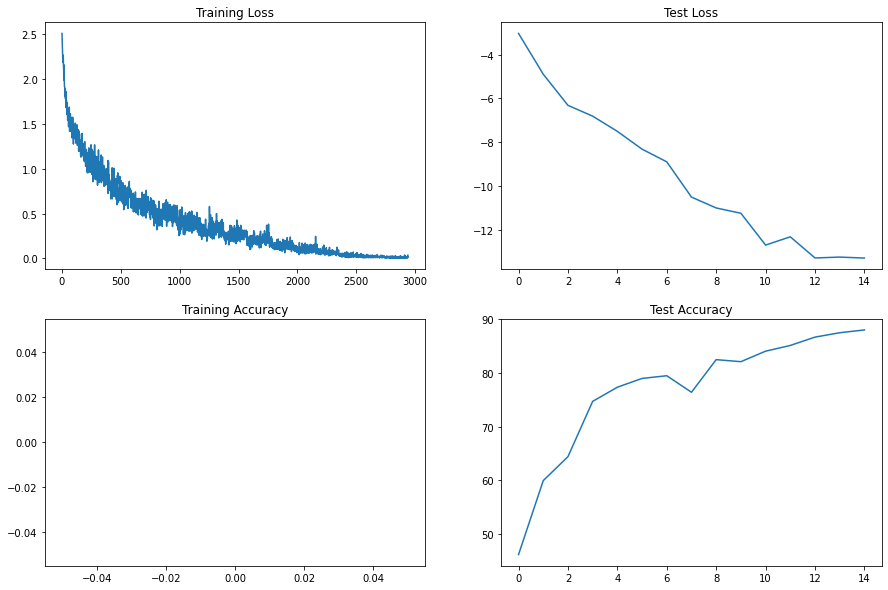

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")